#### Standard 3D RB Convolutional Autoencoder

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, IterableDataset
import torchsummary

import numpy as np
import math
import random

import h5py
import os
import sys
sys.path.append('..')

In [2]:
print('cuda available:', torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cuda available: True


## Data

In [3]:
RB_CHANNELS = 4

BATCH_SIZE = 32

SIMULATION_NAME = '48_48_32_5000_0.7_0.01_0.3_300'

HORIZONTAL_SIZE = int(SIMULATION_NAME.split('_')[0])
HEIGHT = int(SIMULATION_NAME.split('_')[2])

In [4]:
sim_file = os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5')

with h5py.File(sim_file, 'r') as hf:
    N_train = hf['train'].shape[0]
    N_valid = hf['valid'].shape[0]
    N_test = hf['test'].shape[0]
    standardization_mean = np.array(hf['mean'])
    standardization_std = np.array(hf['std'])

In [ ]:
# TODO move data transformation into preparation script

class DataReader(IterableDataset):
    def __init__(self, filename, dataset, num_samples, shuffle=True):
        super().__init__()
        self.filename = filename
        self.dataset = dataset
        self.shuffle = shuffle
        self.num_samples = num_samples

    def generator(self, start=0, end=None):
        if end == None:
            end = self.num_samples
            
        with h5py.File(self.filename, 'r') as hf:
            snapshots = hf[self.dataset]
            
            indices = list(range(start, end))
            if self.shuffle:
                random.shuffle(indices)

            for i in indices:
                snapshot = snapshots[i]
                w, d, h, c = snapshot.shape
                snapshot = snapshot.transpose(2, 3, 0, 1).reshape(h*c, w, d)
                snapshot = torch.Tensor(snapshot).to(device)
                yield snapshot, snapshot
                
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = 0
            iter_end = self.num_samples
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.num_samples) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.num_samples)
        return self.generator(iter_start, iter_end)


train_dataset = DataReader(sim_file, 'train', N_train, shuffle=True)
valid_dataset = DataReader(sim_file, 'valid', N_valid, shuffle=True)
test_dataset = DataReader(sim_file, 'test', N_test, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, drop_last=False)

print('training samples', N_train)
print('validation samples', N_valid)
print('testing samples', N_test)

training samples 4806
validation samples 1602
testing samples 2403


## Model Definition

In [18]:
from models.steerable import RBModel

model = RBModel(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT))
model.to(device)

torchsummary.summary(model, input_size=(4*HEIGHT, HORIZONTAL_SIZE, HORIZONTAL_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
SingleBlockBasisExpansion-1              [-1, 8, 1, 9]               0
SingleBlockBasisExpansion-2              [-1, 8, 2, 9]               0
BlocksBasisExpansion-3                [-1, 12, 9]               0
   RBSteerableConv-4         [-1, 2560, 48, 48]               0
              ReLU-5         [-1, 2560, 48, 48]               0
       BatchNorm3d-6       [-1, 320, 8, 48, 48]             640
    InnerBatchNorm-7         [-1, 2560, 48, 48]               0
  PointwiseDropout-8         [-1, 2560, 48, 48]               0
  SequentialModule-9         [-1, 2560, 48, 48]               0
        RBMaxPool-10         [-1, 1280, 24, 24]               0
SingleBlockBasisExpansion-11              [-1, 8, 8, 9]               0
BlocksBasisExpansion-12               [-1, 240, 9]               0
  RBSteerableConv-13         [-1, 1280, 24, 24]               0
            

## Training

In [19]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

In [20]:
def train_one_epoch():
    running_loss = 0.
    last_loss = 0.

    for i, (inputs, outputs) in enumerate(train_loader):
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        predictions = model(inputs, data_augmentation=True)

        # Compute the loss and its gradients
        loss = loss_fn(predictions, outputs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 20 == 19:
            last_loss = running_loss / 20 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [21]:

from datetime import datetime

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch()


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1
    
    
# TODO Weight initialization
# TODO LR Schedule
# TODO Early stopping

EPOCH 1:
  batch 20 loss: 1.6449263989925385
  batch 40 loss: 1.3699765920639038
  batch 60 loss: 1.2597578853368758
  batch 80 loss: 1.166682505607605
  batch 100 loss: 1.1585380613803864
  batch 120 loss: 1.1747198313474656
  batch 140 loss: 1.1352997034788133
LOSS train 1.1352997034788133 valid 0.9521201252937317
EPOCH 2:
  batch 20 loss: 1.0953984379768371
  batch 40 loss: 1.095194125175476
  batch 60 loss: 1.0147361695766448
  batch 80 loss: 1.0937669545412063
  batch 100 loss: 1.106542557477951
  batch 120 loss: 1.0608970433473588
  batch 140 loss: 1.0387537449598312
LOSS train 1.0387537449598312 valid 0.6818905472755432
EPOCH 3:
  batch 20 loss: 1.0417881160974503
  batch 40 loss: 1.0580535620450973
  batch 60 loss: 1.0563593536615372
  batch 80 loss: 1.0671416997909546
  batch 100 loss: 1.0460770398378372
  batch 120 loss: 1.0270666182041168
  batch 140 loss: 1.045268440246582
LOSS train 1.045268440246582 valid 0.6908766031265259
EPOCH 4:
  batch 20 loss: 1.019275364279747
  ba

## Evaluation

### Equivariance

In [22]:
model.check_equivariance(gpu_device=device)

(+, 0[2pi/4]) 0.0 0.0 0.0
(+, 1[2pi/4]) 0.00042772293 2.2215021e-05 4.576981e-10


AssertionError: The error found during equivariance check with element "(+, 1[2pi/4])"                     is too high: max = 0.0004277229309082031, mean = 2.2215021090232767e-05 var =4.5769810164131286e-10

### MSE

In [23]:
model.eval()

running_test_loss = 0
with torch.no_grad():
    for i, (inputs, outputs) in enumerate(test_loader):
        predictions = model(inputs)
        test_loss = loss_fn(outputs, predictions)
        running_test_loss += test_loss
        
avg_test_loss = running_test_loss / (i + 1)

print(float(avg_test_loss))

0.7733719348907471


### Snapshots

In [24]:
model.eval()

snapshots = next(iter(test_loader))[0][:20]
decoded = model(snapshots)

snapshots = snapshots.cpu().detach().numpy()
decoded = decoded.cpu().detach().numpy()

snapshots = snapshots.reshape(20, HEIGHT, RB_CHANNELS, HORIZONTAL_SIZE, HORIZONTAL_SIZE).transpose(0, 3, 4, 1, 2)
decoded = decoded.reshape(20, HEIGHT, RB_CHANNELS, HORIZONTAL_SIZE, HORIZONTAL_SIZE).transpose(0, 3, 4, 1, 2)

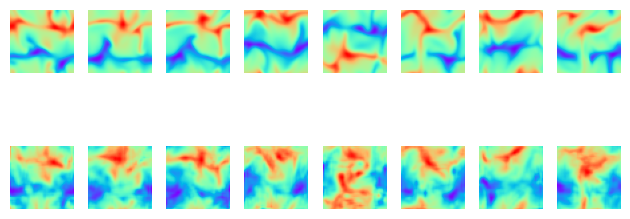

In [25]:
from matplotlib import pyplot as plt

snapshots_unstandardized = snapshots*standardization_std+standardization_mean
decoded_unstandardized = decoded*standardization_std+standardization_mean

for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(snapshots_unstandardized[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()

    plt.subplot(2, 8, 8+i+1)
    plt.imshow(decoded_unstandardized[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()
plt.show()

### Animation

In [26]:
# use raw simulation data for animation since train/valid/test datasets are shuffled
def get_sim_data():
    sim_file = h5py.File(os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5'), 'r')
    return sim_file, sim_file['test']


def predict_batch(sim_data, i, size):
    """Calculates the models output of a batch of raw simulation data."""
    # prepare input
    orig = sim_data[i*size:(i+1)*size, :, :, :, :]
    
    b, w, d, h, c = orig.shape
    inputs = orig.transpose(0, 3, 4, 1, 2).reshape(b, h*c, w, d)
    inputs = torch.Tensor(inputs).to(device)
    
    # predict
    model.eval()
    pred = model(inputs)
    
    pred = pred.cpu().detach().numpy()
    pred = pred.reshape(b, h, c, w, d).transpose(0, 3, 4, 1, 2)
    
    # remove standardization
    orig_unstandardized = orig*standardization_std + standardization_mean
    pred_unstandardized = pred*standardization_std + standardization_mean
    return orig_unstandardized, pred_unstandardized

In [27]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def auto_encoder_animation(axis, animation_name, slice, fps, batch_size=32):
    """Animates the output of a AE next to the input across a 2D slice.

    Args:
        axis: 0, 1, 2 for slices across the width, depth or height axis respectively
    """
    sim_file, sim_data = get_sim_data()
    
    batch_x, batch_y = predict_batch(sim_data, 0, batch_size)
    current_batch_nr = 0

    # prepare plot
    if axis == 2:
        # is square when looking from above
        img_extent = [0, 2*np.pi, 0, 2*np.pi]
    else:
        img_extent = [0, 2*np.pi, 0, 2]
    fig = plt.figure()
    ax = plt.subplot(1,2,1)
    orig_im = plt.imshow(np.rot90(batch_x[0, :, :, :, 0].take(indices=slice, axis=axis)), cmap='rainbow', extent=img_extent)
    plt.axis('off')
    ax.set_title('input')

    ax = plt.subplot(1,2,2)
    pred_im = plt.imshow(np.rot90(batch_y[0, :, :, :, 0].take(indices=slice, axis=axis)), cmap='rainbow', extent=img_extent)
    plt.axis('off')
    ax.set_title('output')
    
    def frame_updater(frame):
        """Computes the next frame of the animation."""
        nonlocal batch_x, batch_y, current_batch_nr
        
        required_batch_nr, in_batch_frame = frame//batch_size, frame%batch_size
        if required_batch_nr > current_batch_nr:
            # required to predict next batch
            current_batch_nr = required_batch_nr
            batch_x, batch_y = predict_batch(sim_data, required_batch_nr, batch_size)
        
        # update frames
        orig_data = np.rot90(batch_x[in_batch_frame, :, :, :, 0].take(indices=slice, axis=axis))
        pred_data = np.rot90(batch_y[in_batch_frame, :, :, :, 0].take(indices=slice, axis=axis))
        orig_im.set_array(orig_data)
        pred_im.set_array(pred_data)
        
        # update color map limits
        vmin = min(np.min(orig_data), np.min(pred_data))
        vmax = max(np.max(orig_data), np.max(pred_data))
        orig_im.set_clim(vmin=vmin, vmax=vmax)
        pred_im.set_clim(vmin=vmin, vmax=vmax)
        
        return orig_im, pred_im
    
    anim = animation.FuncAnimation(fig, frame_updater, frames=sim_data.shape[0], interval=1000/fps, blit=True)
    anim.save(f'{animation_name}.mp4')
    
    sim_file.close()

**Width slice**

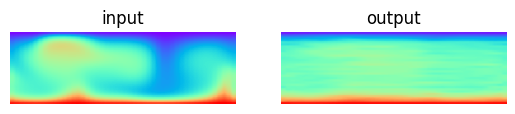

In [28]:
auto_encoder_animation(axis=0, animation_name='animations/width', slice=24, fps=30)

from IPython.display import Video
Video("animations/width.mp4")

**Depth slice**

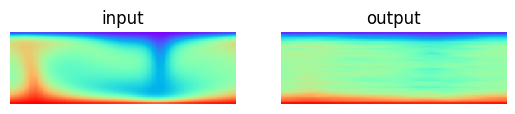

In [29]:
auto_encoder_animation(axis=1, animation_name='animations/depth', slice=24, fps=30)

from IPython.display import Video
Video("animations/depth.mp4")

**Height slice**

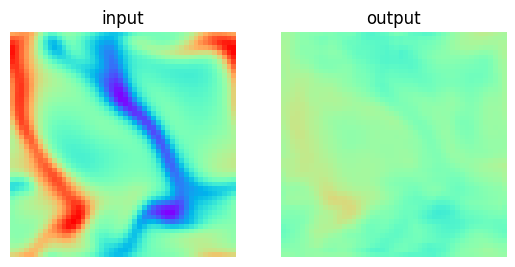

In [30]:
auto_encoder_animation(axis=2, animation_name='animations/height', slice=16, fps=30)

from IPython.display import Video
Video("animations/height.mp4")